In [1]:
# Importing Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *

from sklearn import preprocessing
from sklearn import compose
from sklearn import cross_decomposition
from sklearn import decomposition
from sklearn import model_selection
from sklearn import linear_model
from sklearn import pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold

In [2]:
df = pd.read_csv("../EDA/cleaned_data.csv")
df_Train =  pd.read_csv("../EDA/train.csv")
df_Test =  pd.read_csv("../EDA/test.csv")

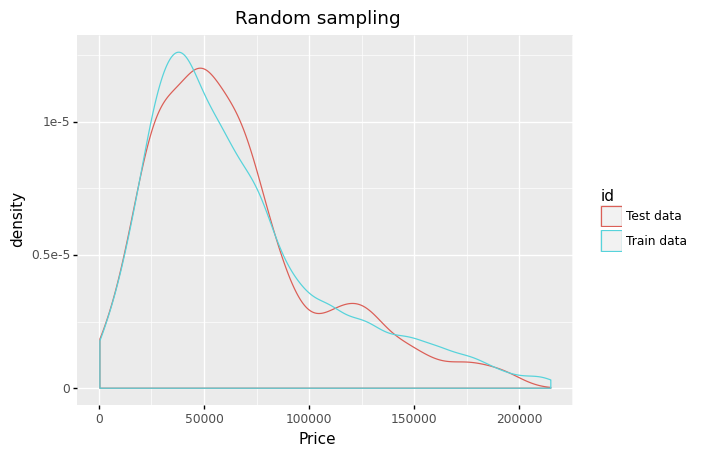

<ggplot: (126429674346)>

In [3]:
df_Train['id'] = 'Train data'
df_Test['id'] = 'Test data'

(ggplot(pd.concat([df_Train, df_Test]), aes('Price', color='id'))
 + geom_density()
 + ggtitle("Random sampling"))

In [4]:
X_train = df_Train.drop("Price", axis=1)
y_train = df_Train[["Price"]]

# linear

In [18]:
# create linear regression model object
lm_mod = linear_model.LinearRegression()

# fit linear model with only Mileage feature
lm_fit = lm_mod.fit(X_train[["Mileage"]], y_train)

In [19]:
lm_fit.intercept_

array([80183.58513603])

In [20]:
lm_fit.coef_

array([[-0.10929821]])

# mulitlinear

In [8]:
# create linear regression model object
lm_mod = linear_model.LinearRegression()

# fit linear model with only Mileage and Year feature
lm_fit = lm_mod.fit(X_train[["Mileage", "Year"]], y_train)

In [9]:
lm_fit.intercept_

array([-5405652.41106861])

In [10]:
lm_fit.coef_

array([[-5.90554388e-02,  2.71961573e+03]])

In [11]:
# create linear regression model object
lm_mod = linear_model.LinearRegression()

# use PolynomialFeatures to create main Mileage and Year effects and
# also an interaction effect between Mileage & Year
effects = preprocessing.PolynomialFeatures(
  interaction_only=True,
  include_bias=False
  )
features = effects.fit_transform(X_train[["Mileage", "Year"]])

# fit linear model with only Mileage and Year feature and
# also include an interaction effect (Mileage:Year)
lm_fit = lm_mod.fit(features, y_train)

In [12]:
lm_fit.coef_


array([[ 8.15751868e+00,  3.22766872e+03, -4.08446317e-03]])

In [13]:
# create new feature set with categorical features dummy encoded
encoder = preprocessing.OneHotEncoder(drop='first')
cat_feat_only = compose.make_column_selector(dtype_include="object")
preprocessor = compose.ColumnTransformer(
  remainder="passthrough",
  transformers=[("one-hot", encoder, cat_feat_only)]
  )
X_train_encoded = preprocessor.fit_transform(X_train)

# MLR model with new dummy encoded feature set
lm_mod = linear_model.LinearRegression()
lm_fit = lm_mod.fit(X_train_encoded, y_train)

In [14]:
lm_fit.coef_[0, 0:10]

array([ 12171.81627669,  50983.08662232,  30880.25610428, -14364.0728711 ,
        -7428.91023743,  -4532.51384489,    968.56862223,  72247.38736687,
        -5221.44150897,  -4866.28899779])

In [15]:
# feature sets to compare across
feature_set1 = X_train[["Mileage"]]
feature_set2 = X_train[["Mileage", "Year"]]
feature_set3 = X_train_encoded
feature_sets = {'lm1': feature_set1, 'lm2': feature_set2, 'lm3': feature_set3}

# define loss function
loss = 'neg_root_mean_squared_error'

# create 10 fold CV object
kfold = model_selection.KFold(n_splits=10, random_state=8451, shuffle=True)

# object to store CV RMSE results
results = {}

for name, feat in feature_sets.items():
  # create LM model object
  lm_mod = linear_model.LinearRegression()

  # execute and score the cross validation procedure
  cv_results = model_selection.cross_val_score(
    estimator=lm_mod, 
    X=feat, 
    y=y_train, 
    cv=kfold, 
    scoring=loss
    )
  results[name] = np.absolute(cv_results.mean())

In [16]:
results


{'lm1': 42450.75492842747,
 'lm2': 40567.055772620304,
 'lm3': 24221.648291308626}

In [28]:
# create linear model object
lm_mod = linear_model.LinearRegression()

# create k-fold cross validation object
kfold = model_selection.KFold(n_splits=5, random_state=8451, shuffle=True)

# define loss function
loss = 'neg_root_mean_squared_error'

# create our preprocessing steps which includes performing PCA 
# with 3 components
scaler = preprocessing.StandardScaler()
pca = decomposition.PCA(n_components=3)
encoder = preprocessing.OneHotEncoder(handle_unknown="ignore")
num_feat_only = compose.make_column_selector(dtype_include="number")
cat_feat_only = compose.make_column_selector(dtype_include="object")

# combine all steps into a pre-processing pipeline
preprocessor = compose.ColumnTransformer(
  remainder="passthrough",
  transformers=[
  ("std_encode", scaler, num_feat_only),
  ("pca_encode", pca, num_feat_only),
  ("one-hot", encoder, cat_feat_only),
  ])

# create a pipeline object that combines model with recipe
model_pipeline = pipeline.Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("lm", lm_mod),
])

# train and fit our model
cv_results = model_selection.cross_val_score(
  estimator=model_pipeline, 
  X=X_train, 
  y=y_train, 
  cv=kfold, 
  scoring=loss
  )

# get results
np.absolute(cv_results.mean())

24580.346943299148

In [35]:
kfold = model_selection.KFold(n_splits=5, random_state=8451, shuffle=True)

# define loss function
loss = 'neg_root_mean_squared_error'

# create our preprocessing steps
scaler = preprocessing.StandardScaler()
encoder = preprocessing.OneHotEncoder(handle_unknown="ignore")
num_feat_only = compose.make_column_selector(dtype_include="number")
cat_feat_only = compose.make_column_selector(dtype_include="object")

# create object to save results
results = {}

# iterate over over 1, 2, 3, ..., 3 components and train model
for n_comp in range(1, 4, 1):
  # create PCA object with n components
  pca = decomposition.PCA(n_components=n_comp)
  
# combine all steps into a pre-processing pipeline
  preprocessor = compose.ColumnTransformer(
    remainder="passthrough",
    transformers=[
    ("std_encode", scaler, num_feat_only),
    ("pca_encode", pca, num_feat_only),
    ("one-hot", encoder, cat_feat_only),
    ])

  # create linear model object
  lm_mod = linear_model.LinearRegression()

  # create a pipeline object that combines model with recipe
  model_pipeline = pipeline.Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("lm", lm_mod),
  ])

  # train and fit our model
  cv_results = model_selection.cross_val_score(
    estimator=model_pipeline, 
    X=X_train, 
    y=y_train, 
    cv=kfold, 
    scoring=loss
    )

  # get results
  results[n_comp] = np.absolute(cv_results.mean())

In [31]:
pd.DataFrame.from_dict(
  results,
  orient='index',
  columns=['RMSE']
  ).rename_axis('n_components').reset_index()

,n_components,RMSE
0,1,24594.802907
1,2,24608.050802
2,3,24580.346943


In [36]:
# create linear model object
pls_mod = cross_decomposition.PLSRegression()

# create k-fold cross validation object
kfold = model_selection.KFold(n_splits=5, random_state=8451, shuffle=True)

# define loss function
loss = 'neg_root_mean_squared_error'

# create our preprocessing steps to normalize and one-hot encode
scaler = preprocessing.StandardScaler()
encoder = preprocessing.OneHotEncoder(handle_unknown="ignore", sparse=False)
num_feat_only = compose.make_column_selector(dtype_include="number")
cat_feat_only = compose.make_column_selector(dtype_include="object")

# combine all steps into a pre-processing pipeline
preprocessor = compose.ColumnTransformer(
  remainder="passthrough",
  transformers=[
    ("std_encode", scaler, num_feat_only),
    ("one-hot", encoder, cat_feat_only),
  ])

# create a pipeline object that combines model with recipe
model_pipeline = pipeline.Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("pls", pls_mod),
])

# Create grid of hyperparameter values
hyper_grid = {'pls__n_components': range(1, 4, 1)}

# Tune a knn model using grid search
grid_search = model_selection.GridSearchCV(
  model_pipeline, 
  hyper_grid, 
  cv=kfold, 
  scoring=loss
  )
  
results = grid_search.fit(X_train, y_train)

# Best model's cross validated RMSE
abs(results.best_score_)

26070.152472470596

In [37]:
results.best_estimator_.get_params().get('pls__n_components')

3